In [454]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import yfinance as yf
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA as arima

In [455]:
class StockData:
    def __init__(self, ticker_name, start_date, end_date):
        import plotly.graph_objects
        import yfinance
        OHLC = ["Open", "High", "Low", "Close"]
        self.history = yfinance.Ticker(ticker_name).history(
                start = start_date, 
                end = end_date,
                interval = '1d'
            )
        self.candlestick = plotly.graph_objects.Figure(
            data=[
                plotly.graph_objects.Candlestick(
                    x=self.history.index,
                    open=self.history['Open'],
                    high=self.history['High'],
                    low=self.history['Low'],
                    close=self.history['Close']
                )
            ]
        )
        self.candlestick.update_xaxes(
            rangebreaks=[ 
                { 'values': ['2023-01-02', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-06-19', '2023-07-04', '2023-09-04'] },
                { 'pattern': 'day of week', 'bounds': ['sat', 'mon']},
                #{ 'pattern': 'hour', 'bounds':[16,9.5]}
            ]
        )
        self.line = plotly.graph_objects.Figure(
            data=[
                plotly.graph_objects.Scatter(
                    x=self.history.index,
                    y=self.history['High'],
                    name = "High"
                ),
                plotly.graph_objects.Scatter(
                    x=self.history.index,
                    y=self.history['Low'],
                    name = "Low"
                    
                ),
                plotly.graph_objects.Scatter(
                    x=self.history.index,
                    y=self.history['Close'],
                    name = "Close"
                    
                )                
            ]
        )
        self.line.update_xaxes(
            rangebreaks=[ 
                { 'pattern': 'day of week', 'bounds': ['sat', 'mon']},
                #{ 'pattern': 'hour', 'bounds':[16,9.5]}
            ]
        )

In [456]:
import datetime
import statsmodels.api as sm

starting_time = datetime.date(2023, 6, 1)
ending_time = datetime.date.today() #+ datetime.timedelta(days = 30) #5)
#previous = starting_time - datetime.timedelta(weeks=1)

google = StockData("GOOG", starting_time, ending_time)
google.candlestick.show()
google.line.show()

### Analyzing the Behavior of the Mean and General Trend

In [457]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(google.history['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.180178
p-value: 0.682064
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


In [458]:
diff_data = google.history['Close'].diff(1).dropna()
diff_data_result = adfuller(diff_data)
print('ADF Statistic: %f' % diff_data_result[0])
print('p-value: %f' % diff_data_result[1])
print('Critical Values:')
for key, value in diff_data_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.774089
p-value: 0.000001
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592


<Axes: xlabel='Date'>

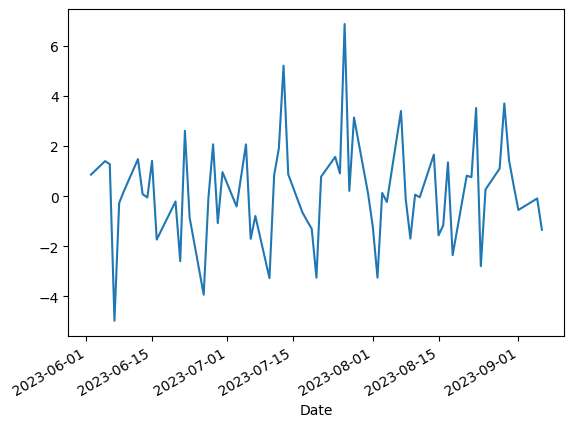

In [459]:
diff_data.plot()

From: https://medium.com/analytics-vidhya/arima-fc1f962c22d4#:~:text=The%20partial%20autocorrelation%20at%20lag,we%20use%20the%20MA%20term.

#### Autoregression Component (AR): 
A purely AR Model forecast only using a combination of the past values sorta like linear regression where the number of AR terms used is directly proportional to the number of previous periods taken into consideration for the forecasting.

Use AR terms in the model when the:

- ACF plots show autocorrelation decaying towards zero
- PACF plot cuts off quickly towards zero
- ACF of a stationary series shown positive at lag -1

#### Moving Averages (MA): 
Random jumps in the time series plot whose effect is felt in two or more consecutive periods. These jumps represent the error calculated in our ARIMA model and represent what the MA component would lag for. A purely MA model would smooth out these sudden jumps like the exponential smoothing method.

Use MA terms in the model when the model is

- Negatively Autocorrelated at Lag — 1
- ACF that drops sharply after a few lags
- PACF decreases more gradually

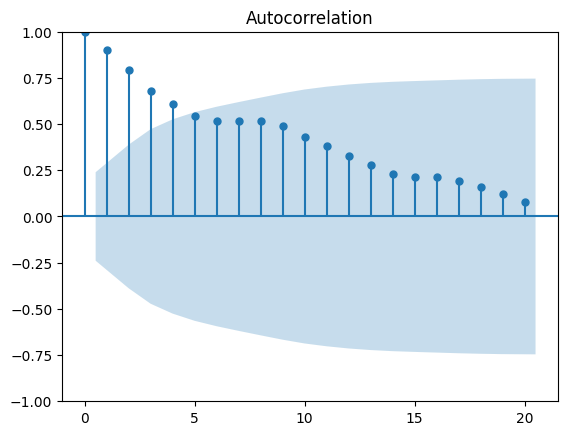

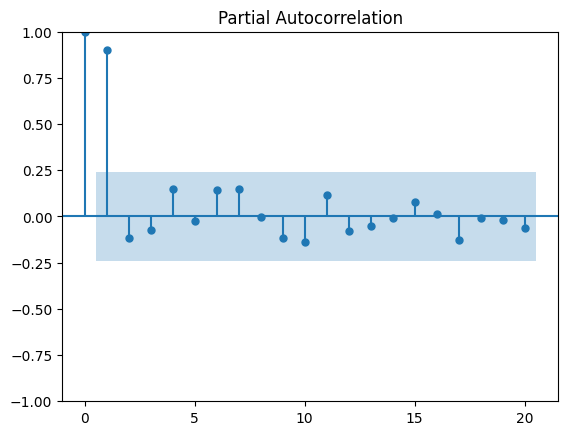

In [460]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#lag1_acf = plot_acf(google.history['Close'].values, lags = 1)
acf = plot_acf(google.history['Close'].values, lags = 20)
pacf = plot_pacf(google.history['Close'].values, lags = 20)

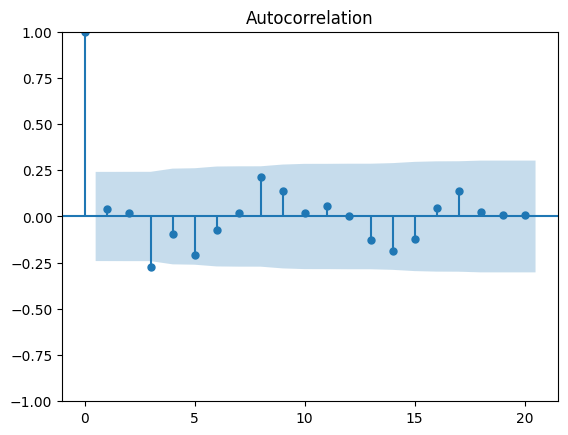

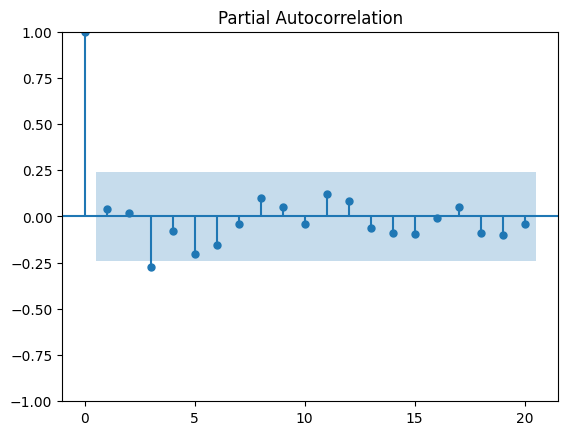

In [461]:
#lag1_acf = plot_acf(google.history['Close'].values, lags = 1)
acf = plot_acf(diff_data.values, lags = 20)
pacf = plot_pacf(diff_data.values, lags = 20)

c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `star

<Axes: >

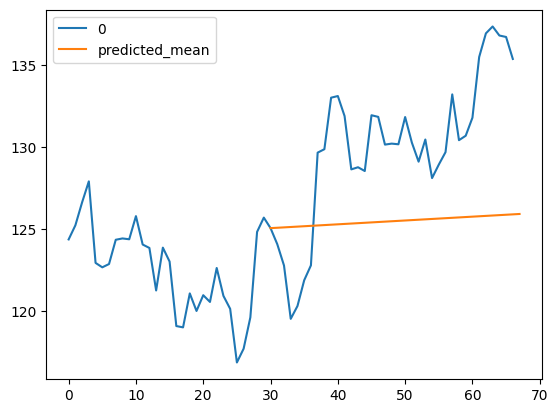

In [462]:
from statsmodels.tsa.arima.model import ARIMA

error_results = []

for p in range (5):
    for d in range (5):
        for q in range (5):
            arima_model = ARIMA(diff_data, order = (p, d, q))
            fitted_model = arima_model.fit()
            #print(fitted_model.summary())
            #dataframe = pd.concat([diff_data, fitted_model.predict()], axis = 'columns')
            #dataframe.plot(title="Differentiated Data & Prediction")

            strt = 30
            inv_model = fitted_model.predict(start=strt, end=67, dynamic = True)
            inv_model[strt] = google.history['Close'].values[strt]
            inv_model = inv_model.cumsum()

            comparison_data = pd.DataFrame(google.history['Close'].values)[30:]
            print(comparison_data)

            #predict_df = pd.concat([original_data, inv_model], axis = 'columns')
            #predict_df.plot()